In [1]:
import os
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import torchvision
import tifffile as tiff
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from copy import deepcopy
import random


In [2]:
# Load the saved day 7 features
loaded_day7_feats = torch.load('combined_cond7.pt')

# Load the saved day 10 features
loaded_day10_feats = torch.load('combined_cond10.pt')

# Verify the shapes
print(f"Loaded Day 7 Features Shape: {loaded_day7_feats.shape}")
print(f"Loaded Day 10 Features Shape: {loaded_day10_feats.shape}")


Loaded Day 7 Features Shape: torch.Size([780, 512])
Loaded Day 10 Features Shape: torch.Size([780, 512])


C:\Users\k54739\AppData\Local\Temp\ipykernel_20544\3131424418.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_day7_feats = torch.load('combined_cond7.pt')
C:\User

In [3]:
train_day7_feats = loaded_day7_feats 
train_day10_feats = loaded_day10_feats 

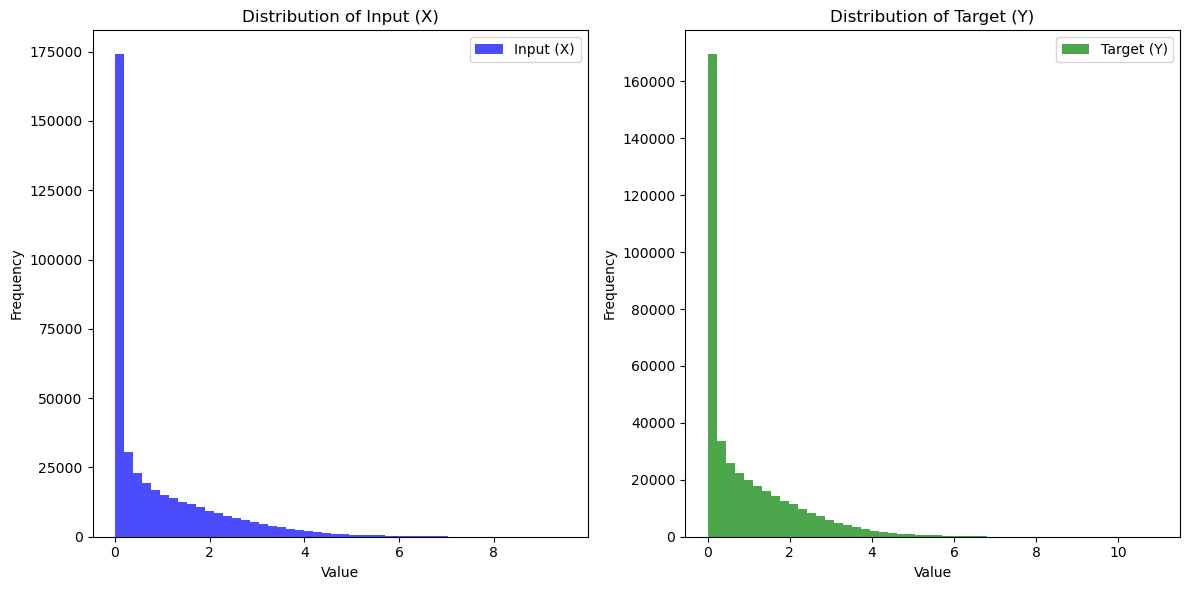

Input (X): Mean=0.8961, Std=1.1917
Target (Y): Mean=0.9076, Std=1.1527


In [4]:
import matplotlib.pyplot as plt

# Plot histograms for input (X) and target (Y)
plt.figure(figsize=(12, 6))

# Flatten tensors to 1D for easier visualization
train_day7_feats_flat = train_day7_feats.flatten().cpu().numpy()
train_day10_feats_flat = train_day10_feats.flatten().cpu().numpy()

# Input (X) histogram
plt.subplot(1, 2, 1)
plt.hist(train_day7_feats_flat, bins=50, color='blue', alpha=0.7, label='Input (X)')
plt.title('Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram
plt.subplot(1, 2, 2)
plt.hist(train_day10_feats_flat, bins=50, color='green', alpha=0.7, label='Target (Y)')
plt.title('Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"Input (X): Mean={train_day7_feats.mean():.4f}, Std={train_day7_feats.std():.4f}")
print(f"Target (Y): Mean={train_day10_feats.mean():.4f}, Std={train_day10_feats.std():.4f}")


In [5]:
# Min-Max Scaling for Input (X) and Target (Y)
def min_max_scaling(data):
    data_min = data.min()
    data_max = data.max()
    return (data - data_min) / (data_max - data_min), data_min, data_max  # Return scaled data and min/max for inverse scaling

# Apply Min-Max Scaling
train_day7_feats_minmaxed, day7_min, day7_max = min_max_scaling(train_day7_feats)
train_day10_feats_minmaxed, day10_min, day10_max = min_max_scaling(train_day10_feats)

# Print summary to confirm
print("After Min-Max Scaling:")
print(f"Input (X): Min={train_day7_feats_minmaxed.min():.4f}, Max={train_day7_feats_minmaxed.max():.4f}")
print(f"Target (Y): Min={train_day10_feats_minmaxed.min():.4f}, Max={train_day10_feats_minmaxed.max():.4f}")



After Min-Max Scaling:
Input (X): Min=0.0000, Max=1.0000
Target (Y): Min=0.0000, Max=1.0000


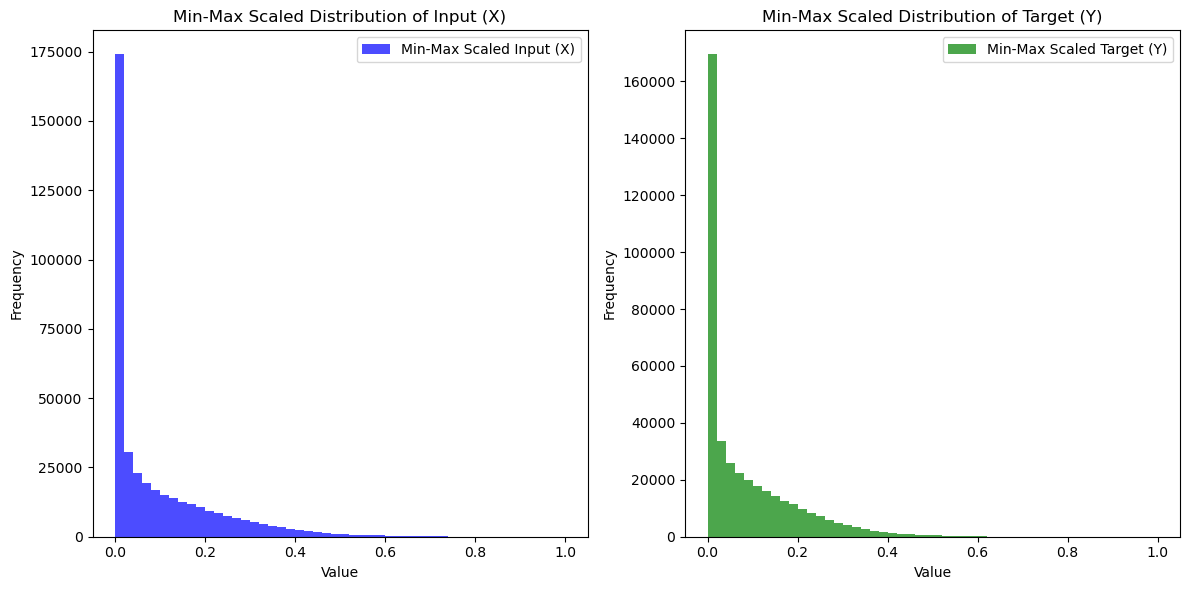

In [6]:
import matplotlib.pyplot as plt

# Flatten the tensors for easier visualization
train_day7_feats_minmaxed_flat = train_day7_feats_minmaxed.flatten().cpu().numpy()
train_day10_feats_minmaxed_flat = train_day10_feats_minmaxed.flatten().cpu().numpy()

# Plot histograms
plt.figure(figsize=(12, 6))

# Input (X) histogram after Min-Max scaling
plt.subplot(1, 2, 1)
plt.hist(train_day7_feats_minmaxed_flat, bins=50, color='blue', alpha=0.7, label='Min-Max Scaled Input (X)')
plt.title('Min-Max Scaled Distribution of Input (X)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

# Target (Y) histogram after Min-Max scaling
plt.subplot(1, 2, 2)
plt.hist(train_day10_feats_minmaxed_flat, bins=50, color='green', alpha=0.7, label='Min-Max Scaled Target (Y)')
plt.title('Min-Max Scaled Distribution of Target (Y)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.tight_layout()
plt.show()


In [7]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

class FeaturePredictor(nn.Module):
    def __init__(self, input_size=512, output_size=512):
        super(FeaturePredictor, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16,32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, output_size)
        )
    
    def forward(self, x):
        return self.model(x)

In [8]:
model = FeaturePredictor()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


In [9]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset

In [10]:
from torch.utils.data import TensorDataset

optimizer_class = torch.optim.Adam



In [11]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import numpy as np
import torch


In [12]:

class EarlyStopping:
    def __init__(self, patience=10, delta=0.0):
        """
        Args:
            patience (int): How many epochs to wait after the last validation loss improvement.
            delta (float): Minimum change in the validation loss to qualify as an improvement.
        """
        self.patience = patience
        self.delta = delta
        self.best_loss = None
        self.no_improvement_epochs = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_epochs = 0
        else:
            self.no_improvement_epochs += 1
            if self.no_improvement_epochs >= self.patience:
                self.early_stop = True


def cross_validate_with_early_stopping(
    model_class, dataset, criterion, optimizer_class, num_epochs=50, n_splits=5, patience=10, device='cuda'
):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    histories = []
    best_models = []

    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset)):
        print(f"Fold {fold + 1}/{n_splits}")

        # Create subsets for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)

        # Create DataLoaders
        train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

        # Initialize the model, optimizer, and early stopping for this fold
        model = model_class().to(device)
        optimizer = optimizer_class(model.parameters(), lr=1e-4)
        early_stopping = EarlyStopping(patience=patience)

        # Training and validation loop
        history = {'train_loss': [], 'val_loss': []}
        for epoch in range(num_epochs):
            # Training phase
            model.train()
            train_loss = 0.0
            for batch_inputs, batch_targets in train_loader:
                batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)

                # Forward pass
                outputs = model(batch_inputs)
                loss = criterion(outputs, batch_targets)
                train_loss += loss.item()

                # Backward pass and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            train_loss /= len(train_loader)
            history['train_loss'].append(train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_inputs, batch_targets in val_loader:
                    batch_inputs, batch_targets = batch_inputs.to(device), batch_targets.to(device)
                    outputs = model(batch_inputs)
                    loss = criterion(outputs, batch_targets)
                    val_loss += loss.item()

            val_loss /= len(val_loader)
            history['val_loss'].append(val_loss)

            print(f"Epoch [{epoch + 1}/{num_epochs}] Fold {fold + 1}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Check early stopping
            early_stopping(val_loss)
            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch + 1} for fold {fold + 1}")
                break

        # Save the best model for this fold
        best_models.append(model.state_dict())
        histories.append(history)

    return histories, best_models



In [13]:
# MIN MAX
dataset = TensorDataset(train_day7_feats_minmaxed, train_day10_feats_minmaxed)

cv_histories, best_models = cross_validate_with_early_stopping(
    model_class=FeaturePredictor,
    dataset=dataset,
    criterion=nn.MSELoss(),
    optimizer_class=torch.optim.Adam,
    num_epochs=2000,
    patience=500
)


Fold 1/5
Epoch [1/2000] Fold 1, Train Loss: 0.0187, Val Loss: 0.0182
Epoch [2/2000] Fold 1, Train Loss: 0.0164, Val Loss: 0.0160
Epoch [3/2000] Fold 1, Train Loss: 0.0141, Val Loss: 0.0136
Epoch [4/2000] Fold 1, Train Loss: 0.0119, Val Loss: 0.0117
Epoch [5/2000] Fold 1, Train Loss: 0.0106, Val Loss: 0.0109
Epoch [6/2000] Fold 1, Train Loss: 0.0101, Val Loss: 0.0106
Epoch [7/2000] Fold 1, Train Loss: 0.0099, Val Loss: 0.0105
Epoch [8/2000] Fold 1, Train Loss: 0.0099, Val Loss: 0.0105
Epoch [9/2000] Fold 1, Train Loss: 0.0098, Val Loss: 0.0105
Epoch [10/2000] Fold 1, Train Loss: 0.0098, Val Loss: 0.0105
Epoch [11/2000] Fold 1, Train Loss: 0.0098, Val Loss: 0.0105
Epoch [12/2000] Fold 1, Train Loss: 0.0099, Val Loss: 0.0105
Epoch [13/2000] Fold 1, Train Loss: 0.0098, Val Loss: 0.0105
Epoch [14/2000] Fold 1, Train Loss: 0.0098, Val Loss: 0.0105
Epoch [15/2000] Fold 1, Train Loss: 0.0098, Val Loss: 0.0105
Epoch [16/2000] Fold 1, Train Loss: 0.0099, Val Loss: 0.0105
Epoch [17/2000] Fold 1, 

In [14]:
# Example: Average validation loss across folds
avg_val_loss = np.mean([history['val_loss'][-1] for history in cv_histories])
print(f"Average Validation Loss: {avg_val_loss:.4f}")


Average Validation Loss: 0.0024


In [15]:
# Analyze the best results for each fold outside the training function
for fold_idx, history in enumerate(cv_histories):
    # Find the epoch with the lowest validation loss
    best_epoch = int(np.argmin(history['val_loss'])) + 1  # Adding 1 because epochs are 1-indexed
    best_val_loss = history['val_loss'][best_epoch - 1]  # Accessing the loss using 0-based index
    best_train_loss = history['train_loss'][best_epoch - 1]

    print(f"Fold {fold_idx + 1}:")
    print(f"  Best Validation Loss = {best_val_loss:.4f}")
    print(f"  Corresponding Training Loss = {best_train_loss:.4f}")
    print(f"  Best Epoch = {best_epoch}")


Fold 1:
  Best Validation Loss = 0.0016
  Corresponding Training Loss = 0.0005
  Best Epoch = 1941
Fold 2:
  Best Validation Loss = 0.0018
  Corresponding Training Loss = 0.0004
  Best Epoch = 1965
Fold 3:
  Best Validation Loss = 0.0015
  Corresponding Training Loss = 0.0005
  Best Epoch = 1989
Fold 4:
  Best Validation Loss = 0.0037
  Corresponding Training Loss = 0.0022
  Best Epoch = 1978
Fold 5:
  Best Validation Loss = 0.0030
  Corresponding Training Loss = 0.0010
  Best Epoch = 1974


In [16]:
import torch

# Save each fold's best model to the current directory
for i, model_state in enumerate(best_models):
    save_path = f'best_model_fold_{i+1}.pth'  # Save in the current directory
    torch.save(model_state, save_path)

print("Models saved to the current directory.")


Models saved to the current directory.


In [17]:
def plot_loss_curves_separately(cv_histories):
    """
    Plot training and validation loss curves for each fold in separate figures.
    
    Args:
        cv_histories (list): List of loss histories for each fold.
    """
    # Plot Training Loss
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(cv_histories):
        epochs = range(1, len(history['train_loss']) + 1)  # Dynamically set range
        plt.plot(epochs, history['train_loss'], label=f'Fold {fold + 1} Train Loss')
    plt.title('Training Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot Validation Loss
    plt.figure(figsize=(10, 6))
    for fold, history in enumerate(cv_histories):
        epochs = range(1, len(history['val_loss']) + 1)  # Dynamically set range
        plt.plot(epochs, history['val_loss'], label=f'Fold {fold + 1} Val Loss', linestyle='--')
    plt.title('Validation Loss per Fold')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()


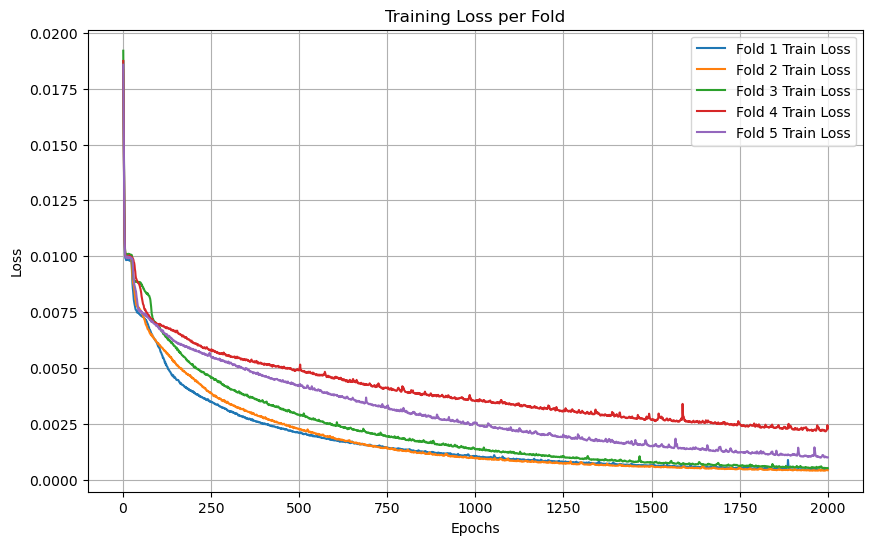

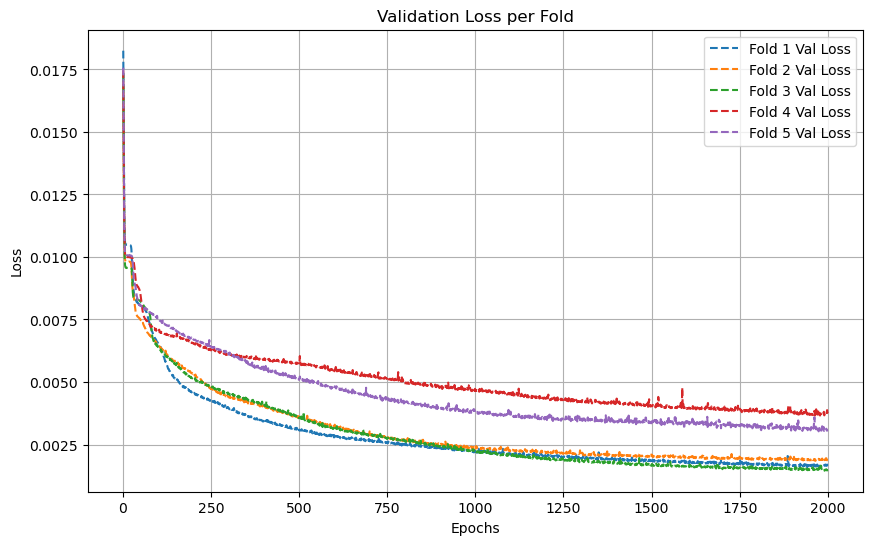

In [18]:
import matplotlib.pyplot as plt
plot_loss_curves_separately(cv_histories)
